In [4]:
import pandas as pd

def load_data(file_path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(file_path, delimiter=";", encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(file_path, delimiter=";", encoding="latin1")

def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    cols_to_num = [
        "poblacion_total", "numero_hogares", "area_ha",
        "estrato_promedio", "deficit_habitacional"
    ]
    for col in cols_to_num:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    if "año" in df.columns:
        df["año"] = pd.to_numeric(df["año"], downcast="integer", errors='coerce')
    return df

def check_nulls(df: pd.DataFrame):
    print("\nNull values per column:")
    print(df.isnull().sum())

def data_summary(df: pd.DataFrame):
    print("\nDescriptive summary:")
    print(df.describe(include='all'))

def preview_data(df: pd.DataFrame, n: int = 10):
    print(f"\nPreview of the first {n} rows:")
    print(df.head(n))

file_path = '/content/datos_sinteticos_cartagena_3200.csv'
df = load_data(file_path)
df = clean_columns(df)
preview_data(df, n=10)
check_nulls(df)
data_summary(df)


Preview of the first 10 rows:
     barrio   año  poblacion_total  numero_hogares  area_ha  estrato_promedio  \
0  Barrio_1  2010             5159            2039     0.91                 5   
1  Barrio_1  2011            23183           10518    19.57                 2   
2  Barrio_1  2012            17133            7852    11.26                 2   
3  Barrio_1  2013            29292            6669    12.74                 6   
4  Barrio_1  2014            36243            9903     3.19                 3   
5  Barrio_1  2015            29578            5491    10.26                 6   
6  Barrio_1  2016            45715            8648     4.68                 6   
7  Barrio_1  2017            41248            8125     4.65                 1   
8  Barrio_1  2018            22735            5952    13.13                 6   
9  Barrio_1  2019             3804            1299    15.91                 6   

  codigo_geo  deficit_habitacional  
0     CG_327                   606  
1  

In [5]:
import json

def ejemplo_barrios_criticos(df, año):
    fragment = df[df["año"] == año][["barrio", "deficit_habitacional"]]
    fragment = fragment.sort_values("deficit_habitacional", ascending=False)
    criticos = fragment[fragment["deficit_habitacional"] > 2500]
    contexto = "\n".join([f"{r.barrio}: {int(r.deficit_habitacional)}" for _, r in fragment.iterrows()])
    respuesta = ", ".join(criticos.barrio.tolist())
    return {
        "prompt": f"Pregunta: ¿Cuáles son los barrios con déficit habitacional crítico en {año}?\n"
                  f"Contexto:\n{contexto}\n"
                  "Categoría: Crítico >2500\nResponde SOLO con la lista de barrios críticos, separados por coma.",
        "completion": respuesta if respuesta else "No hay barrios críticos en ese año."
    }

def ejemplo_deficit_barrio(df, barrio, año):
    fragment = df[(df["año"] == año) & (df["barrio"] == barrio)]
    if fragment.empty:
        return None
    deficit = int(fragment.iloc[0]["deficit_habitacional"])
    contexto = f"{barrio} en {año}: {deficit}"
    return {
        "prompt": f"Pregunta: ¿Cuál es el déficit habitacional de {barrio} en {año}?\n"
                  f"Contexto:\n{contexto}",
        "completion": f"{deficit}"
    }

def ejemplo_top_barrio(df, año):
    fragment = df[df["año"] == año][["barrio", "deficit_habitacional"]]
    fragment = fragment.sort_values("deficit_habitacional", ascending=False)
    top = fragment.iloc[0]
    contexto = "\n".join([f"{r.barrio}: {int(r.deficit_habitacional)}" for _, r in fragment.head(5).iterrows()])
    return {
        "prompt": f"Pregunta: ¿Cuál es el barrio con mayor déficit habitacional en {año}?\n"
                  f"Contexto:\n{contexto}\nResponde SOLO con el nombre del barrio.",
        "completion": top.barrio
    }

ejemplos = []
for año in sorted(df["año"].unique()):
    ejemplos.append(ejemplo_barrios_criticos(df, año))
    ejemplos.append(ejemplo_top_barrio(df, año))

# Tomamos una muestra mucho mayor, por ejemplo 600 en vez de 150
for idx, row in df.sample(600, random_state=42).iterrows():
    ej = ejemplo_deficit_barrio(df, row["barrio"], row["año"])
    if ej:
        ejemplos.append(ej)

with open('/content/cartagena_rag_finetune.jsonl', 'w', encoding='utf-8') as f:
    for ej in ejemplos:
        f.write(json.dumps(ej, ensure_ascii=False) + '\n')

print(f"Generados {len(ejemplos)} ejemplos RAG-style para fine-tuning.")

Generados 632 ejemplos RAG-style para fine-tuning.


In [6]:
with open('/content/cartagena_rag_finetune.jsonl', 'r', encoding='utf-8') as fin, \
     open('/content/cartagena_rag_finetune.txt', 'w', encoding='utf-8') as fout:
    for line in fin:
        obj = json.loads(line)
        fout.write(obj["prompt"].strip() + "\n" + obj["completion"].strip() + "\n\n")

In [7]:
import torch, gc
torch.cuda.empty_cache(); gc.collect()

from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, TextDataset, DataCollatorForLanguageModeling

model_name = "bigscience/bloomz-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

def get_dataset(file_path, tokenizer, block_size=64):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

train_dataset = get_dataset('/content/cartagena_rag_finetune.txt', tokenizer, block_size=64)
eval_dataset = train_dataset

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

training_args = TrainingArguments(
    output_dir="/content/bloomz-cartagena-rag-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    save_steps=300,
    logging_steps=100,
    learning_rate=5e-5,
    warmup_steps=30,
    report_to="none",
    fp16=False,
    gradient_accumulation_steps=4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

trainer.train()

trainer.save_model("/content/bloomz-cartagena-rag-finetuned")
tokenizer.save_pretrained("/content/bloomz-cartagena-rag-finetuned")
print("¡Fine-tuning RAG completado!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss
100,1.567800
200,1.320500
300,1.262800
400,1.178100
500,1.089900
600,0.980500
700,0.950800
800,0.782800


¡Fine-tuning RAG completado!


In [8]:
from transformers import pipeline

finetuned_path = "/content/bloomz-cartagena-rag-finetuned"
pipe = pipeline("text-generation", model=finetuned_path, tokenizer=finetuned_path, max_new_tokens=60, device=0)

Device set to use cuda:0


In [9]:
import re
import time

def construir_contexto_barrios_criticos(df, año, top_n=10):
    fragment = df[(df["año"] == año) & (df["deficit_habitacional"] > 2500)]
    fragment = fragment.sort_values("deficit_habitacional", ascending=False).head(top_n)
    contexto = "\n".join([f"{r.barrio}: {int(r.deficit_habitacional)}" for _, r in fragment.iterrows()])
    return contexto

def limpiar_lista_barrios_bloomz(respuesta):
    splitters = [
        "sin repetir y sin agregar ningún texto extra.",
        "separados por coma, sin repetir y sin agregar ningún texto extra.",
        "Responde SOLO con la lista de barrios críticos, separados por coma.",
        "Responde SOLO con la lista de barrios críticos, separados por coma"
    ]
    for splitter in splitters:
        if splitter in respuesta:
            respuesta = respuesta.split(splitter)[-1].strip()
            break
    barrios = re.findall(r'Barrio_\d+', respuesta)
    return list(dict.fromkeys(barrios))

def consultar_barrios_criticos(pipe, df, año, top_n=10, verbose=True):
    contexto = construir_contexto_barrios_criticos(df, año, top_n)
    prompt = (
        f"Pregunta: ¿Cuáles son los barrios con déficit habitacional crítico en {año}?\n"
        f"Contexto:\n{contexto}\n"
        "Categoría: Crítico >2500\n"
        "Responde SOLO con los nombres exactos de los barrios críticos del contexto, separados por coma, sin repetir y sin agregar ningún texto extra."
    )
    t0 = time.time()
    salida = pipe(prompt, max_new_tokens=60)[0]["generated_text"]
    t1 = time.time()
    if verbose:
        print("Prompt usado:\n", prompt)
        print("\nRespuesta cruda del modelo:\n", salida)
        print(f"\nTiempo de inferencia: {t1-t0:.2f} segundos")
    barrios_limpios = limpiar_lista_barrios_bloomz(salida)
    print("\nBarrios críticos extraídos:", barrios_limpios)
    return barrios_limpios

# Ejemplo de uso
barrios_predichos = consultar_barrios_criticos(pipe, df, 2019, top_n=10)

Prompt usado:
 Pregunta: ¿Cuáles son los barrios con déficit habitacional crítico en 2019?
Contexto:
Barrio_105: 4950
Barrio_177: 4915
Barrio_139: 4902
Barrio_194: 4887
Barrio_9: 4887
Barrio_109: 4797
Barrio_134: 4752
Barrio_17: 4747
Barrio_148: 4582
Barrio_122: 4502
Categoría: Crítico >2500
Responde SOLO con los nombres exactos de los barrios críticos del contexto, separados por coma, sin repetir y sin agregar ningún texto extra.

Respuesta cruda del modelo:
 Pregunta: ¿Cuáles son los barrios con déficit habitacional crítico en 2019?
Contexto:
Barrio_105: 4950
Barrio_177: 4915
Barrio_139: 4902
Barrio_194: 4887
Barrio_9: 4887
Barrio_109: 4797
Barrio_134: 4752
Barrio_17: 4747
Barrio_148: 4582
Barrio_122: 4502
Categoría: Crítico >2500
Responde SOLO con los nombres exactos de los barrios críticos del contexto, separados por coma, sin repetir y sin agregar ningún texto extra.Barrio_105, Barrio_177, Barrio_139, Barrio_181, Barrio_92, Barrio_146, Barrio_121, Barrio_146, Barrio_111, Barrio_14

In [10]:
# Celda 7: Métricas completas
from sacrebleu.metrics import BLEU
from rouge_score import rouge_scorer

def barrios_criticos_gt(df, año, top_n=10):
    fragment = df[(df["año"] == año) & (df["deficit_habitacional"] > 2500)]
    fragment = fragment.sort_values("deficit_habitacional", ascending=False).head(top_n)
    return fragment["barrio"].tolist()

def evaluar_bloomz_criticos(respuesta_limpia, barrios_gt):
    set_pred = set([b.lower() for b in respuesta_limpia])
    set_gt = set([b.lower() for b in barrios_gt])
    aciertos = set_pred & set_gt
    recall = len(aciertos) / len(set_gt) if set_gt else 0
    precision = len(aciertos) / len(set_pred) if set_pred else 0
    f1 = 2 * recall * precision / (recall + precision + 1e-9) if (recall + precision) else 0
    accuracy = int([b.lower() for b in respuesta_limpia][:len(barrios_gt)] == [b.lower() for b in barrios_gt])
    bleu = BLEU().corpus_score([" ".join(respuesta_limpia)], [[" ".join(barrios_gt)]]).score
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    rouge = scorer.score(" ".join(barrios_gt), " ".join(respuesta_limpia))['rougeL'].fmeasure
    ranks = [i+1 for i, b in enumerate(respuesta_limpia) if b.lower() in set_gt]
    mrr = 1.0 / ranks[0] if ranks else 0.0
    print(f"Real:      {barrios_gt}")
    print(f"Predicho:  {respuesta_limpia}")
    print(f"Aciertos:  {aciertos}")
    print(f"Recall:    {recall:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"F1:        {f1:.2%}")
    print(f"Accuracy:  {accuracy:.2%}")
    print(f"BLEU:      {bleu:.2f}")
    print(f"ROUGE-L:   {rouge:.2%}")
    print(f"MRR:       {mrr:.2f}")
    return {
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "accuracy": accuracy,
        "bleu": bleu,
        "rougeL": rouge,
        "mrr": mrr
    }

# Ejemplo de evaluación:
barrios_gt = barrios_criticos_gt(df, 2019, top_n=10)
metricas = evaluar_bloomz_criticos(barrios_predichos, barrios_gt)

Real:      ['Barrio_105', 'Barrio_177', 'Barrio_139', 'Barrio_194', 'Barrio_9', 'Barrio_109', 'Barrio_134', 'Barrio_17', 'Barrio_148', 'Barrio_122']
Predicho:  ['Barrio_105', 'Barrio_177', 'Barrio_139', 'Barrio_181', 'Barrio_92', 'Barrio_146', 'Barrio_121', 'Barrio_111']
Aciertos:  {'barrio_177', 'barrio_139', 'barrio_105'}
Recall:    30.00%
Precision: 37.50%
F1:        33.33%
Accuracy:  0.00%
BLEU:      40.77
ROUGE-L:   61.11%
MRR:       1.00



Barrios críticos extraídos: ['Barrio_44', 'Barrio_146', 'Barrio_107', 'Barrio_162', 'Barrio_50', 'Barrio_113', 'Barrio_43', 'Barrio_121', 'Barrio_179', 'Barrio_111']

Barrios críticos extraídos: ['Barrio_105', 'Barrio_125', 'Barrio_181', 'Barrio_54', 'Barrio_100', 'Barrio_146', 'Barrio_111', 'Barrio_91', 'Barrio_166', 'Barrio_162']

Barrios críticos extraídos: ['Barrio_105', 'Barrio_166', 'Barrio_43', 'Barrio_121', 'Barrio_69', 'Barrio_50', 'Barrio_44', 'Barrio_111']

Barrios críticos extraídos: ['Barrio_113', 'Barrio_146', 'Barrio_177', 'Barrio_50', 'Barrio_121', 'Barrio_76', 'Barrio_40', 'Barrio_166', 'Barrio_111']

Barrios críticos extraídos: ['Barrio_26', 'Barrio_113', 'Barrio_146', 'Barrio_181', 'Barrio_111', 'Barrio_92', 'Barrio_66', 'Barrio_50', 'Barrio_23']

Barrios críticos extraídos: ['Barrio_105', 'Barrio_146', 'Barrio_181', 'Barrio_100', 'Barrio_111', 'Barrio_166']

Barrios críticos extraídos: ['Barrio_21', 'Barrio_44', 'Barrio_78', 'Barrio_166', 'Barrio_181', 'Barrio_92',

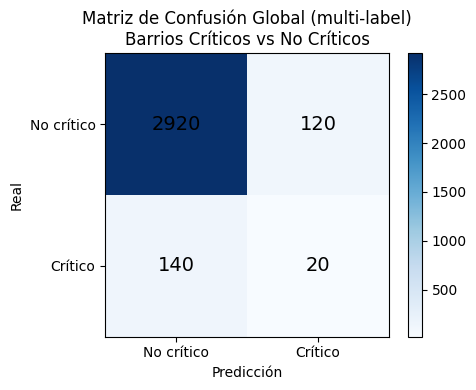

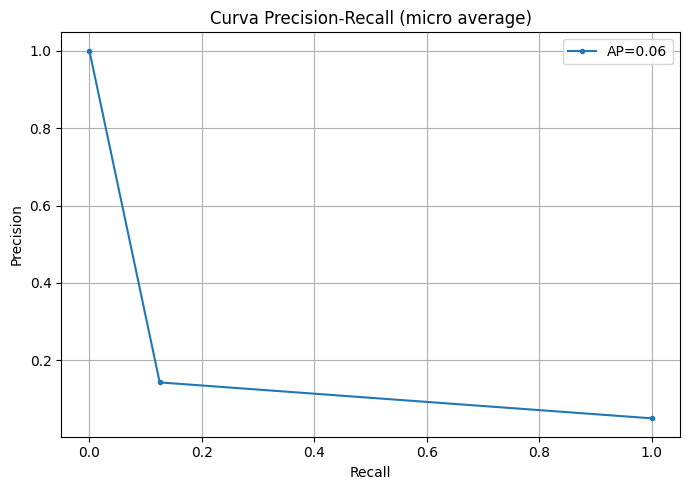

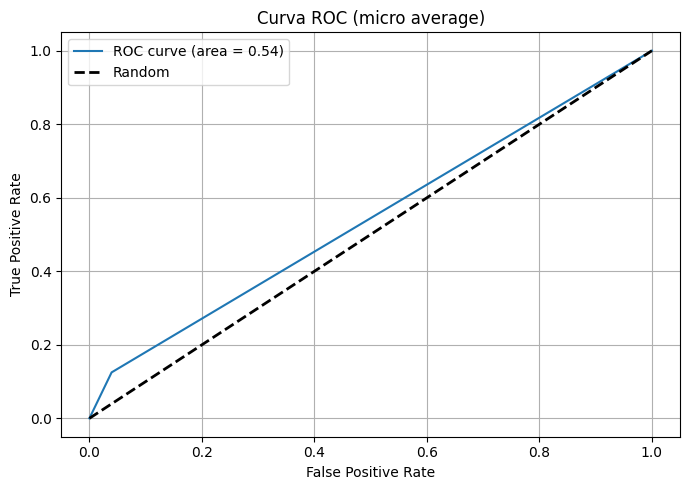


Barrios críticos extraídos: ['Barrio_44', 'Barrio_146', 'Barrio_107', 'Barrio_162', 'Barrio_50', 'Barrio_113', 'Barrio_43', 'Barrio_121', 'Barrio_179', 'Barrio_111']

Barrios críticos extraídos: ['Barrio_105', 'Barrio_125', 'Barrio_181', 'Barrio_54', 'Barrio_100', 'Barrio_146', 'Barrio_111', 'Barrio_91', 'Barrio_166', 'Barrio_162']

Barrios críticos extraídos: ['Barrio_105', 'Barrio_166', 'Barrio_43', 'Barrio_121', 'Barrio_69', 'Barrio_50', 'Barrio_44', 'Barrio_111']

Barrios críticos extraídos: ['Barrio_113', 'Barrio_146', 'Barrio_177', 'Barrio_50', 'Barrio_121', 'Barrio_76', 'Barrio_40', 'Barrio_166', 'Barrio_111']

Barrios críticos extraídos: ['Barrio_26', 'Barrio_113', 'Barrio_146', 'Barrio_181', 'Barrio_111', 'Barrio_92', 'Barrio_66', 'Barrio_50', 'Barrio_23']

Barrios críticos extraídos: ['Barrio_105', 'Barrio_146', 'Barrio_181', 'Barrio_100', 'Barrio_111', 'Barrio_166']

Barrios críticos extraídos: ['Barrio_21', 'Barrio_44', 'Barrio_78', 'Barrio_166', 'Barrio_181', 'Barrio_92',

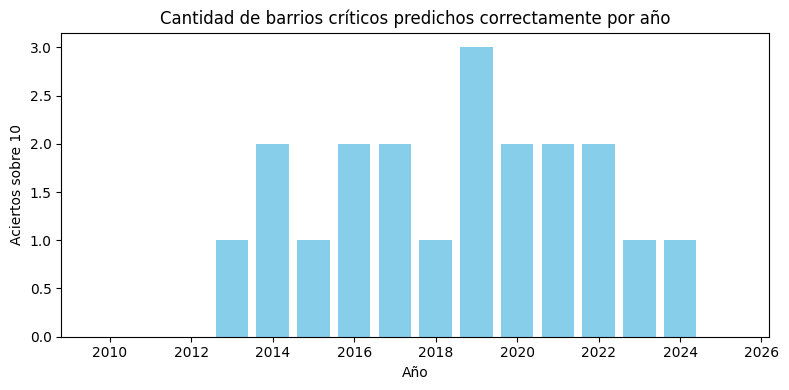

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc

# 1. Lista de todos los barrios
all_barrios = sorted(df["barrio"].unique())

# 2. Función para convertir listas de barrios a multi-hot (binario)
def to_multihot(barrios, all_barrios):
    return [1 if b in barrios else 0 for b in all_barrios]

# 3. Prepara ground truth y predicciones para todos los años
gt = []
pred = []
anios = sorted(df["año"].unique())
for año in anios:
    gt_barrios = [b.lower() for b in barrios_criticos_gt(df, año, top_n=10)]
    pred_barrios = [b.lower() for b in consultar_barrios_criticos(pipe, df, año, top_n=10, verbose=False)]
    gt.append(to_multihot(gt_barrios, [b.lower() for b in all_barrios]))
    pred.append(to_multihot(pred_barrios, [b.lower() for b in all_barrios]))

gt = np.array(gt)
pred = np.array(pred)

# 4. Matriz de confusión global (multi-label)
mcm = multilabel_confusion_matrix(gt, pred)
global_cm = np.sum(mcm, axis=0)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(global_cm, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No crítico', 'Crítico'])
ax.set_yticklabels(['No crítico', 'Crítico'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Global (multi-label)\nBarrios Críticos vs No Críticos")
for i in range(2):
    for j in range(2):
        ax.text(j, i, int(global_cm[i, j]), ha="center", va="center", color="black", fontsize=14)
plt.colorbar(im)
plt.tight_layout()
plt.show()

# 5. Curva Precision-Recall (micro average)
precision, recall, _ = precision_recall_curve(gt.ravel(), pred.ravel())
ap = average_precision_score(gt, pred, average="micro")
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker='.', label=f'AP={ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (micro average)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Curva ROC (Receiver Operating Characteristic)
fpr, tpr, _ = roc_curve(gt.ravel(), pred.ravel())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (micro average)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7. (Opcional) Histograma de aciertos por año
aciertos_por_ano = []
for año in anios:
    gt_barrios = [b.lower() for b in barrios_criticos_gt(df, año, top_n=10)]
    pred_barrios = [b.lower() for b in consultar_barrios_criticos(pipe, df, año, top_n=10, verbose=False)]
    aciertos = len(set(gt_barrios) & set(pred_barrios))
    aciertos_por_ano.append(aciertos)

plt.figure(figsize=(8, 4))
plt.bar(anios, aciertos_por_ano, color="skyblue")
plt.xlabel("Año")
plt.ylabel("Aciertos sobre 10")
plt.title("Cantidad de barrios críticos predichos correctamente por año")
plt.tight_layout()
plt.show()